# **1.- Introducción**

La segmentación de imágenes es una tarea fundamental en aplicaciones de visión por computador, especialmente en el ámbito biomédico, donde es necesario identificar regiones de interés a nivel de píxel. UNet es una de las arquitecturas de Deep Learning más utilizadas para ello, gracias a su estructura encoder–decoder con conexiones de salto, que permite combinar información semántica y espacial de forma eficiente, incluso con conjuntos de datos reducidos.

No obstante, el rendimiento de una UNet depende en gran medida de la correcta elección de hiperparámetros, parámetros arquitectónicos y estrategias de entrenamiento.

En este trabajo se analiza de forma sistemática el efecto de distintos parámetros sobre el rendimiento de una arquitectura UNet, evaluando su impacto mediante las métricas de segmentación IoU, Dice y F1-score.

# **2.- Descargar el dataset**

El conjunto de datos utilizado se descarga directamente desde Kaggle mediante la librería kagglehub, lo que permite obtener la versión más reciente del dataset de forma automática. Una vez descargado, el dataset se almacena localmente y se obtiene la ruta de acceso para su posterior uso en el proceso de carga y entrenamiento del modelo.

In [5]:
import kagglehub

# Download latest version
download_path = kagglehub.dataset_download("nikitamanaenkov/fundus-image-dataset-for-vessel-segmentation")

print("Path to dataset files:", download_path)

100%|██████████| 1.64G/1.64G [00:14<00:00, 121MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nikitamanaenkov/fundus-image-dataset-for-vessel-segmentation/versions/6


# **3.- Importación de librerías**

Importación de las librerías básicas que tenía el notebook asignado por defecto.

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization,Conv2DTranspose,Activation,concatenate,Input
from tensorflow.keras import Sequential,Model
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import matplotlib.pyplot as plt

# **4.- Arquitectura del modelo base**



# 4.1- Definición de bloques básicos

Esta celda define los bloques fundamentales de la arquitectura UNet. El conv_block se encarga de la extracción jerárquica de características mediante convoluciones consecutivas con normalización y activación. El encoder_block implementa el camino contractivo, reduciendo progresivamente la resolución espacial y almacenando mapas de características para las conexiones de salto. El decoder_block implementa el camino expansivo, recuperando resolución mediante convoluciones transpuestas y combinando información semántica y espacial gracias a las skip connections, permitiendo una segmentación precisa a nivel de píxel.

In [7]:
def conv_block(input,filters):
    x = Conv2D(filters,3,padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters,3,padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def encoder_block(input,filters):

    x = conv_block(input,filters)
    p = MaxPooling2D((2,2))(x)
    return x,p

def decoder_block(input,skip,filters):

    x = Conv2DTranspose(filters,2,strides=2,padding="same")(input)
    x = concatenate([x,skip])
    x = conv_block(x,filters)
    return x


# 4.2- Arquitectura completa U-Net

En esta celda se define la arquitectura completa de la UNet mediante la función build_model. El modelo recibe imágenes RGB de 512×512 píxeles y está compuesto por un encoder de cuatro niveles que reduce progresivamente la resolución espacial mientras aumenta la profundidad de características. Se establece un bloque convolucional profundo que actúa como bottleneck, capturando información semántica global. El decoder reconstruye la resolución original mediante convoluciones transpuestas y conexiones de salto que fusionan información de bajo y alto nivel. Finalmente, una convolución 1×1 con activación sigmoide genera el mapa de probabilidad de segmentación binaria a nivel de píxel.

In [8]:
def build_model():
    input = Input(shape=(512,512,3))

    x1,p1 = encoder_block(input,64)
    x2,p2 = encoder_block(p1,128)
    x3,p3 = encoder_block(p2,256)
    x4,p4 = encoder_block(p3,512)

    a1 = conv_block(p4,1024)

    d1 = decoder_block(a1,x4,512)
    d2 = decoder_block(d1,x3,256)
    d3 = decoder_block(d2,x2,128)
    d4 = decoder_block(d3,x1,64)

    output = Conv2D(1,(1,1),padding="same",activation="sigmoid")(d4)
    model = Model(input,output)
    return model

# 4.3- Carga y procesado dataset

En esta celda se define la función de carga y preprocesado básico del dataset (imágenes + máscaras) antes de entrenar la UNet.

In [9]:
def load_data(path, img_size):
    images, masks = [], []
    num_images = 100

    img_list  = sorted(os.listdir(path + "/Original"))[:num_images]
    mask_list = sorted(os.listdir(path + "/Ground truth"))[:num_images]

    for img_file, mask_file in zip(img_list, mask_list):
        img_path  = os.path.join(path + "/Original", img_file)
        mask_path = os.path.join(path + "/Ground truth", mask_file)

        img  = load_img(img_path,  target_size=img_size)
        mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")

        img  = img_to_array(img) / 255.0
        mask = img_to_array(mask) / 255.0
        mask = (mask > 0.5).astype("float32")  # importante tras redimensionar

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)


Esta celda define la función de data augmentation aplicada durante el entrenamiento. Utilizada porque suele mejorar la generalización sin modificar la arquitectura.

In [10]:
def augment_image(image, mask):

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, mask

En esta celda se cargan los conjuntos de entrenamiento y test utilizando la función de preprocesado anterior. Las imágenes y máscaras se redimensionan a una resolución fija de 512×512 para garantizar compatibilidad con la arquitectura de la red. Además, se verifica la dimensionalidad de los datos cargados para asegurar la correcta correspondencia entre imágenes y máscaras antes de iniciar el entrenamiento.

In [11]:
x_train,y_train = load_data(f"{download_path}/train",img_size=(512,512))
x_test,y_test = load_data(f"{download_path}/test",img_size=(512,512))
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((100, 512, 512, 3),
 (100, 512, 512, 1),
 (100, 512, 512, 3),
 (100, 512, 512, 1))

En esta celda se construye el conjunto de datos de entrenamiento y validación utilizando la API tf.data, con el objetivo de preparar las imágenes y sus máscaras para el entrenamiento de la red neuronal. Para ello, se organizan las muestras en batches, se aleatoriza su orden y se aplican transformaciones de aumento de datos, mejorando así la eficiencia computacional y la robustez del modelo durante el aprendizaje.

In [12]:
def tf_dataset(x,y,batch_size=8):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.shuffle(buffer_size=8)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = tf_dataset(x_train,y_train,batch_size=8)
test_dataset = tf_dataset(x_test,y_test,batch_size=8)

# **5.- Entrenamiento modelo base**

# 5.1- Compilación modelo

En esta celda se compila el modelo definiendo el optimizador, la función de pérdida y las métricas de entrenamiento. Se utiliza el optimizador Adam por su rápida convergencia y estabilidad, junto con la función de pérdida binary cross-entropy, adecuada para problemas de segmentación binaria a nivel de píxel. Aunque se incluye la métrica de accuracy durante el entrenamiento, esta no es representativa del rendimiento real en segmentación, por lo que la evaluación final del modelo se realiza mediante métricas específicas como IoU, Dice y F1-score.

In [13]:
model = build_model()
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

# 5.2- Definición de Callbacks

Se definen los callbacks utilizados durante el entrenamiento del modelo. Se emplea un ModelCheckpoint para guardar automáticamente el modelo con menor pérdida en validación y un EarlyStopping para detener el entrenamiento cuando el rendimiento deja de mejorar, restaurando los mejores pesos. Estos mecanismos permiten reducir el sobreajuste y optimizar el tiempo de entrenamiento, influyendo indirectamente en las métricas finales de segmentación.

In [14]:
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss',
                             save_best_only=True, mode='min', verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min',
                               verbose=1, restore_best_weights=True)

# 5.3- Entrenamiento

En esta celda se entrena el modelo utilizando el conjunto de entrenamiento definido previamente y se monitoriza el rendimiento sobre el conjunto de validación. Se establece un número máximo de 100 epochs, aunque el entrenamiento se detiene de forma automática mediante EarlyStopping cuando la pérdida de validación deja de mejorar. Los callbacks permiten seleccionar el mejor modelo durante el entrenamiento y evitar el sobreajuste, influyendo directamente en el rendimiento final evaluado mediante métricas de segmentación.


In [16]:
history = model.fit(train_dataset,
                    epochs=100,
                    batch_size=8,
                    validation_data=test_dataset,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8536 - loss: 0.4093
Epoch 1: val_loss improved from inf to 1.11051, saving model to best_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 260s 10s/step - accuracy: 0.8568 - loss: 0.4038 - val_accuracy: 0.4519 - val_loss: 1.1105
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9309 - loss: 0.2411
Epoch 2: val_loss did not improve from 1.11051
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.9308 - loss: 0.2412 - val_accuracy: 0.0757 - val_loss: 40.7045
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9321 - loss: 0.2334
Epoch 3: val_loss did not improve from 1.11051
13/13 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9319 - loss: 0.2338 - val_accuracy: 0.0791 - val_loss: 9.8355
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9317 - loss: 0.2323
Epoch 4: val_loss did not improve from 1.11051
13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9316 - loss: 0.2325 - val_accuracy: 0.509

# **6.- Evaluación modelo base**

Una vez finalizado el entrenamiento, se carga desde disco el modelo guardado con menor pérdida en validación. Esta estrategia asegura que las métricas de segmentación se calculen sobre el mejor modelo disponible y no sobre el último estado del entrenamiento, que podría presentar sobreajuste.

In [17]:
from tensorflow.keras.models import load_model
best_model = load_model("best_model.keras", compile=False)


En esta celda se define un pipeline específico para el conjunto de test utilizando la API tf.data, sin aplicar técnicas de data augmentation. El objetivo es evaluar el modelo sobre imágenes no alteradas, de forma que las métricas IoU, Dice y F1-score reflejen el rendimiento real del modelo. El dataset se organiza en batches para optimizar la inferencia y se emplea prefetching para mejorar la eficiencia computacional. De este modo, se garantiza una evaluación justa y reproducible de las distintas configuraciones del modelo.

In [18]:
def tf_dataset_no_aug(x, y, batch_size=8, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(x))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

test_dataset_clean = tf_dataset_no_aug(x_test, y_test, batch_size=8)


En esta celda se implementa la evaluación final del modelo mediante métricas específicas de segmentación: IoU, Dice y F1-score. A partir de las predicciones del modelo sobre el conjunto de test, se binariza la salida usando un umbral fijo y se calcula el solapamiento entre las máscaras predichas y las reales. Estas métricas permiten evaluar la calidad de la segmentación a nivel de píxel y son más representativas que la accuracy en problemas con desbalance entre fondo y objeto. Los valores obtenidos se utilizan para comparar de forma objetiva las distintas configuraciones del modelo.

In [19]:
import numpy as np

def iou_dice_f1(y_true, y_pred, eps=1e-7):
    y_true = y_true.astype(np.float32).reshape(-1)
    y_pred = y_pred.astype(np.float32).reshape(-1)

    inter = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - inter

    iou = (inter + eps) / (union + eps)
    dice = (2*inter + eps) / (np.sum(y_true) + np.sum(y_pred) + eps)
    f1 = dice  # en segmentación binaria, F1 == Dice
    return iou, dice, f1

def evaluate_model(model, ds, threshold=0.5):
    ious, dices, f1s = [], [], []
    for xb, yb in ds:
        pred = model.predict(xb, verbose=0)
        pred_bin = (pred >= threshold).astype(np.float32)
        yb_np = yb.numpy().astype(np.float32)
        iou, dice, f1 = iou_dice_f1(yb_np, pred_bin)
        ious.append(iou); dices.append(dice); f1s.append(f1)
    return float(np.mean(ious)), float(np.mean(dices)), float(np.mean(f1s))

iou, dice, f1 = evaluate_model(best_model, test_dataset_clean, threshold=0.5)
print("Test IoU:", iou, "Dice:", dice, "F1:", f1)


Test IoU: 0.06203106790781021 Dice: 0.11661287397146225 F1: 0.11661287397146225


In [20]:
import pandas as pd
import numpy as np

pd.set_option("display.float_format", "{:.3f}".format)
np.set_printoptions(suppress=True, precision=3)

baseline_results = pd.DataFrame([{
    "Modelo": "Baseline",
    "IoU": iou,
    "Dice": dice,
    "F1_score": f1
}])

baseline_results


,Modelo,IoU,Dice,F1_score
0,Baseline,0.062,0.117,0.117


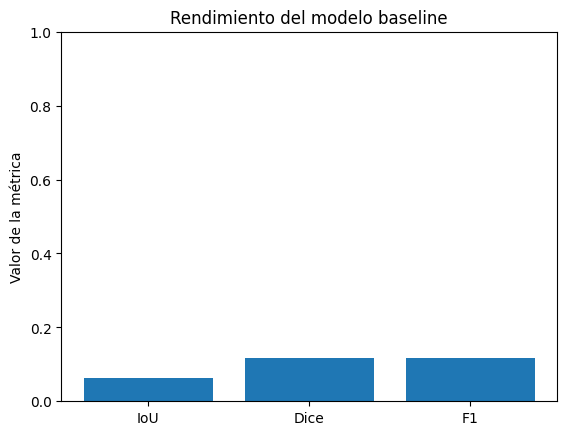

In [21]:
import matplotlib.pyplot as plt

metrics = ["IoU", "Dice", "F1"]
values = [iou, dice, f1]

plt.figure()
plt.bar(metrics, values)
plt.ylim(0, 1)
plt.title("Rendimiento del modelo baseline")
plt.ylabel("Valor de la métrica")
plt.show()


# **7.- Modificación de parámetros sobre el modelo base**

Se irán evaluando distintos parámetros:

*   3 valores (1 por encima y otro por debajo del base) en los numéricos
*   3 opciones en los cualitativos

También se mostrará una tabla con el parámetro a estudiar y los valores de tres métricas distintas: IoU, Dice y F1_score. Además de un gráfico representativo y una evaluación de los resultados


# 7.1- Treshold de inferencia

Umbral utilizado para convertir la probabilidad de salida del modelo en una máscara binaria. Se evaluaron tres valores (0.3, 0.5 y 0.7) para analizar cómo afecta el criterio de decisión a la segmentación final.

In [30]:
import pandas as pd

thresholds = [0.3, 0.5, 0.7]

rows = []
for t in thresholds:
    iou_t, dice_t, f1_t = evaluate_model(best_model, test_dataset_clean, threshold=t)
    rows.append({
        "Aspecto": "Threshold",
        "Valor": t,
        "IoU": iou_t,
        "Dice": dice_t,
        "F1": f1_t
    })

df_threshold = pd.DataFrame(rows)
df_threshold


,Aspecto,Valor,IoU,Dice,F1
0,Threshold,0.300,0.075,0.139,0.139
1,Threshold,0.500,0.062,0.116,0.116
2,Threshold,0.700,0.035,0.067,0.067


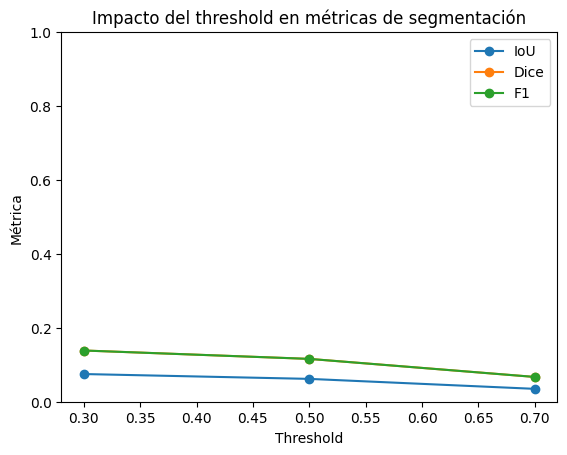

In [31]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df_threshold["Valor"], df_threshold["IoU"], marker="o", label="IoU")
plt.plot(df_threshold["Valor"], df_threshold["Dice"], marker="o", label="Dice")
plt.plot(df_threshold["Valor"], df_threshold["F1"], marker="o", label="F1")
plt.ylim(0, 1)
plt.title("Impacto del threshold en métricas de segmentación")
plt.xlabel("Threshold")
plt.ylabel("Métrica")
plt.legend()
plt.show()


# *Evaluación 7.1*

Se observa que con un threshold de 0.3 el modelo consigue un mejor solapamiento  entre predicción y máscara real, mientras que con valores de 0.5 y 0.7 las métricas son casi cero al predecirse prácticamente todo el fondo. Este comportamiento es coherente ya que estamos en un escenario con fuerte desbalance entre fondo y objeto y recalca la importancia de ajustar el umbral de decisión en segmentación binaria.

# 7.2 Función de pérdida (Loss)

Función objetivo utilizada durante el entrenamiento para optimizar el modelo. Se compararon tres pérdidas distintas (Binary Crossentropy, Dice loss y una combinación BCE+Dice) con el fin de evaluar su influencia en el proceso de aprendizaje.

In [60]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# --- Losses ---
def dice_loss(y_true, y_pred, eps=1e-7):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    inter = tf.reduce_sum(y_true_f * y_pred_f)
    denom = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice = (2.0 * inter + eps) / (denom + eps)
    return 1.0 - dice

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

loss_configs = [
    ("BCE", "binary_crossentropy"),
    ("Dice", dice_loss),
    ("BCE+Dice", bce_dice_loss),
]

# --- Fixed training budget (mantén esto igual en todas las ablations) ---
EPOCHS = 20
PATIENCE = 5
THRESH_EVAL = 0.3  # fijo para comparar losses

rows = []

for loss_name, loss_fn in loss_configs:
    # 1) Construir y compilar
    tf.keras.backend.clear_session()

    model = build_model()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=loss_fn,
                  metrics=["accuracy"])

    # 2) Callbacks con nombre único
    ckpt_path = f"best_loss_{loss_name}.keras"
    checkpoint = ModelCheckpoint(ckpt_path, monitor="val_loss",
                                 save_best_only=True, mode="min", verbose=0)
    early_stopping = EarlyStopping(monitor="val_loss", patience=PATIENCE,
                                   mode="min", verbose=0, restore_best_weights=True)

    # 3) Entrenar
    model.fit(train_dataset,
              epochs=EPOCHS,
              validation_data=test_dataset_clean,
              callbacks=[checkpoint, early_stopping],
              verbose=0)

    # 4) Cargar mejor modelo y evaluar
    best_model = tf.keras.models.load_model(ckpt_path, compile=False)
    iou, dice, f1 = evaluate_model(best_model, test_dataset_clean, threshold=THRESH_EVAL)

    rows.append({
        "Aspecto": "Loss",
        "Valor": loss_name,
        "Threshold_eval": THRESH_EVAL,
        "IoU": iou,
        "Dice": dice,
        "F1": f1
    })

df_loss = pd.DataFrame(rows)
df_loss


,Aspecto,Valor,Threshold_eval,IoU,Dice,F1
0,Loss,BCE,0.300,0.000,0.000,0.000
1,Loss,Dice,0.300,0.652,0.769,0.769
2,Loss,BCE+Dice,0.300,0.627,0.747,0.747


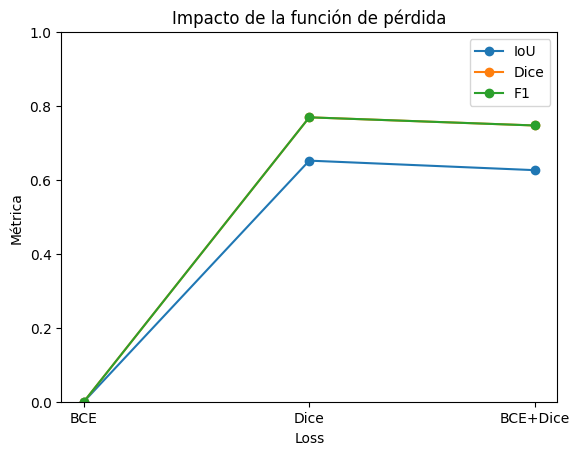

In [61]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df_loss["Valor"], df_loss["IoU"], marker="o", label="IoU")
plt.plot(df_loss["Valor"], df_loss["Dice"], marker="o", label="Dice")
plt.plot(df_loss["Valor"], df_loss["F1"], marker="o", label="F1")
plt.ylim(0, 1)
plt.title("Impacto de la función de pérdida")
plt.xlabel("Loss")
plt.ylabel("Métrica")
plt.legend()
plt.show()


# *Evaluación 7.2*

Con binary_crossentropy el modelo tiende a favorecer la clase mayoritaria (fondo), lo que produce un rendimiento prácticamente nulo. Al utilizar Dice loss, las métricas aumentan enormememte al optimizar directamente el solapamiento entre predicción y máscara real. La combinación BCE+Dice también mejora sustancialmente respecto a BCE.

# 7.3- Learning rate del optimizador Adam

Parámetro que controla el tamaño de los pasos de actualización de los pesos durante el entrenamiento. Se probaron tres valores (1e-4, 1e-3 y 3e-3) para estudiar su efecto en la convergencia del modelo.

In [62]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Fijamos loss ganadora
def dice_loss(y_true, y_pred, eps=1e-7):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    inter = tf.reduce_sum(y_true_f * y_pred_f)
    denom = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice = (2.0 * inter + eps) / (denom + eps)
    return 1.0 - dice

lrs = [1e-4, 1e-3, 3e-3]

EPOCHS = 20
PATIENCE = 5
THRESH_EVAL = 0.3

rows = []

for lr in lrs:
    tf.keras.backend.clear_session()

    model = build_model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=dice_loss,
        metrics=["accuracy"]
    )

    ckpt_path = f"best_lr_{lr}.keras"
    checkpoint = ModelCheckpoint(ckpt_path, monitor="val_loss",
                                 save_best_only=True, mode="min", verbose=0)
    early_stopping = EarlyStopping(monitor="val_loss", patience=PATIENCE,
                                   mode="min", verbose=0, restore_best_weights=True)

    model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=test_dataset_clean,
        callbacks=[checkpoint, early_stopping],
        verbose=0
    )

    best_model = tf.keras.models.load_model(ckpt_path, compile=False)
    iou, dice, f1 = evaluate_model(best_model, test_dataset_clean, threshold=THRESH_EVAL)

    rows.append({
        "Aspecto": "LearningRate",
        "Valor": lr,
        "Threshold_eval": THRESH_EVAL,
        "IoU": iou,
        "Dice": dice,
        "F1": f1
    })

df_lr = pd.DataFrame(rows)
df_lr


,Aspecto,Valor,Threshold_eval,IoU,Dice,F1
0,LearningRate,0.000,0.300,0.645,0.766,0.766
1,LearningRate,0.001,0.300,0.698,0.807,0.807
2,LearningRate,0.003,0.300,0.588,0.726,0.726


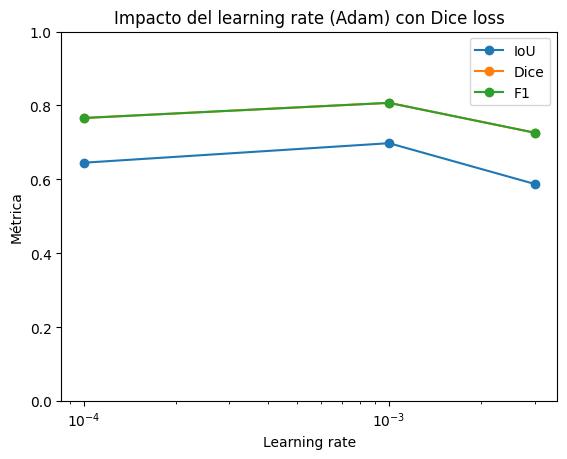

In [63]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df_lr["Valor"], df_lr["IoU"], marker="o", label="IoU")
plt.plot(df_lr["Valor"], df_lr["Dice"], marker="o", label="Dice")
plt.plot(df_lr["Valor"], df_lr["F1"], marker="o", label="F1")
plt.ylim(0, 1)
plt.title("Impacto del learning rate (Adam) con Dice loss")
plt.xlabel("Learning rate")
plt.ylabel("Métrica")
plt.xscale("log")
plt.legend()
plt.show()


# *Evaluación 7.3*

Se observa que un valor intermedio (1e-3) proporciona el mejor rendimiento. Un learning rate demasiado bajo ralentiza la convergencia y uno demasiado alto baja el rendimiento debido a inestabilidad en el entrenamiento.

# 7.4- EarlyStopping: parámetro de paciencia

Número de épocas sin mejora en la métrica de validación tras el cual se detiene el entrenamiento. Se evaluaron tres valores de paciencia (3, 5 y 8) para analizar su impacto en la duración del entrenamiento y la generalización.

In [33]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

PATIENCES = [3, 5, 8]

EPOCHS = 20
LR = 1e-3
THRESH_EVAL = 0.3

rows = []

for p in PATIENCES:
    tf.keras.backend.clear_session()

    model = build_model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
        loss=dice_loss,
        metrics=["accuracy"]
    )

    ckpt_path = f"best_patience_{p}.keras"
    checkpoint = ModelCheckpoint(
        ckpt_path, monitor="val_loss", save_best_only=True, mode="min", verbose=0
    )

    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=p,
        mode="min",
        restore_best_weights=True,
        verbose=0
    )

    model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=test_dataset_clean,
        callbacks=[checkpoint, early_stopping],
        verbose=0
    )

    best_model = tf.keras.models.load_model(ckpt_path, compile=False)
    iou, dice, f1 = evaluate_model(best_model, test_dataset_clean, threshold=THRESH_EVAL)

    rows.append({
        "Aspecto": "EarlyStopping",
        "Valor": p,
        "Threshold_eval": THRESH_EVAL,
        "IoU": iou,
        "Dice": dice,
        "F1": f1
    })

df_patience = pd.DataFrame(rows)
df_patience


,Aspecto,Valor,Threshold_eval,IoU,Dice,F1
0,EarlyStopping,3,0.300,0.089,0.162,0.162
1,EarlyStopping,5,0.300,0.687,0.798,0.798
2,EarlyStopping,8,0.300,0.655,0.771,0.771


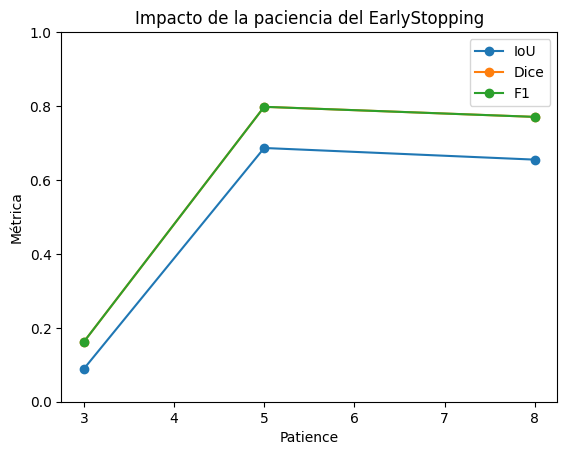

In [34]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df_patience["Valor"], df_patience["IoU"], marker="o", label="IoU")
plt.plot(df_patience["Valor"], df_patience["Dice"], marker="o", label="Dice")
plt.plot(df_patience["Valor"], df_patience["F1"], marker="o", label="F1")
plt.ylim(0, 1)
plt.title("Impacto de la paciencia del EarlyStopping")
plt.xlabel("Patience")
plt.ylabel("Métrica")
plt.legend()
plt.show()


# *Evaluación 7.4*

Una paciencia demasiado baja provoca una detención prematura del entrenamiento, lo que conlleva un rendimiento deficiente. Al aumentar la paciencia se observa una mejora significativa en las métricas, alcanzándose el mejor resultado con un valor intermedio. Valores de paciencia más altos no aportan mejoras adicionales e incluso pueden llegar al sobreajuste.

# 7.5- Número de filtros iniciales de la UNet

Número de filtros utilizados en la primera capa convolucional del encoder, que determina la capacidad inicial del modelo. Se evaluaron tres configuraciones (32, 64 y 128 filtros) manteniendo la estructura relativa del resto de la red.



---


Para evaluar el impacto del número de filtros iniciales en la arquitectura UNet, se definió una versión parametrizada del modelo que permite modificar este valor sin alterar el resto de la estructura. Esta estrategia permite realizar una comparación controlada y aislar el efecto del número de filtros sobre las métricas IoU, Dice y F1.

In [35]:
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Model

def build_model_filters(base_filters=64, input_shape=(512, 512, 3)):
    inputs = Input(shape=input_shape)

    x1, p1 = encoder_block(inputs, base_filters)
    x2, p2 = encoder_block(p1, base_filters * 2)
    x3, p3 = encoder_block(p2, base_filters * 4)
    x4, p4 = encoder_block(p3, base_filters * 8)

    a1 = conv_block(p4, base_filters * 16)

    d1 = decoder_block(a1, x4, base_filters * 8)
    d2 = decoder_block(d1, x3, base_filters * 4)
    d3 = decoder_block(d2, x2, base_filters * 2)
    d4 = decoder_block(d3, x1, base_filters)

    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    return Model(inputs, outputs)


In [36]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

base_filters_list = [32, 64, 128]

LR = 1e-3
THRESH_EVAL = 0.3
EPOCHS = 20
PATIENCE = 5

rows = []

for bf in base_filters_list:
    tf.keras.backend.clear_session()

    model = build_model_filters(base_filters=bf, input_shape=(512, 512, 3))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
        loss=dice_loss,
        metrics=["accuracy"]
    )

    ckpt_path = f"best_filters_{bf}.keras"
    checkpoint = ModelCheckpoint(ckpt_path, monitor="val_loss",
                                 save_best_only=True, mode="min", verbose=0)
    early_stopping = EarlyStopping(monitor="val_loss", patience=PATIENCE,
                                   mode="min", verbose=0, restore_best_weights=True)

    model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=test_dataset_clean,
        callbacks=[checkpoint, early_stopping],
        verbose=0
    )

    best_model = tf.keras.models.load_model(ckpt_path, compile=False)
    iou, dice, f1 = evaluate_model(best_model, test_dataset_clean, threshold=THRESH_EVAL)

    rows.append({
        "Aspecto": "BaseFilters",
        "Valor": bf,
        "Threshold_eval": THRESH_EVAL,
        "IoU": iou,
        "Dice": dice,
        "F1": f1
    })

df_filters = pd.DataFrame(rows)
df_filters


,Aspecto,Valor,Threshold_eval,IoU,Dice,F1
0,BaseFilters,32,0.300,0.699,0.809,0.809
1,BaseFilters,64,0.300,0.687,0.798,0.798
2,BaseFilters,128,0.300,0.070,0.130,0.130


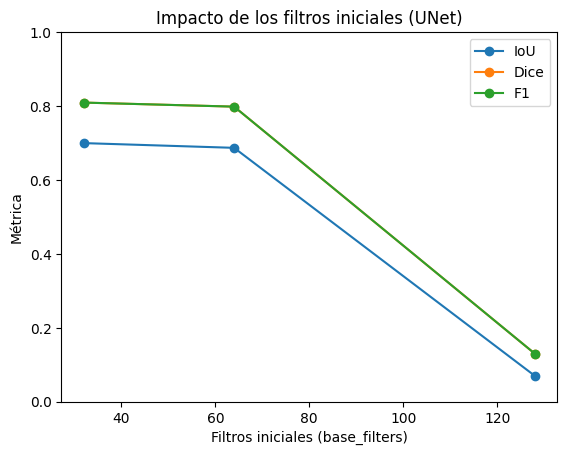

In [37]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df_filters["Valor"], df_filters["IoU"], marker="o", label="IoU")
plt.plot(df_filters["Valor"], df_filters["Dice"], marker="o", label="Dice")
plt.plot(df_filters["Valor"], df_filters["F1"], marker="o", label="F1")
plt.ylim(0, 1)
plt.title("Impacto de los filtros iniciales (UNet)")
plt.xlabel("Filtros iniciales (base_filters)")
plt.ylabel("Métrica")
plt.legend()
plt.show()


# *Evaluación 7.5*

Se observa que un número reducido de filtros permite obtener el mejor equilibrio entre capacidad del modelo y generalización. Al aumentar excesivamente el número de filtros, el rendimiento cae de forma drástica, indicando un modelo demasiado complejo para el tamaño del conjunto de datos. Estos resultados ponen de manifiesto la importancia de ajustar la capacidad del modelo al problema concreto.

# 7.6- Número máximo de epochs

Número máximo de iteraciones completas sobre el conjunto de entrenamiento permitidas durante el entrenamiento. Se analizaron tres valores (10, 20 y 30) en combinación con EarlyStopping.

In [38]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

epoch_list = [10, 20, 30]

LR = 1e-3
THRESH_EVAL = 0.3
PATIENCE = 5  # fijo
BASE_FILTERS = 32

rows = []

for EPOCHS in epoch_list:
    tf.keras.backend.clear_session()

    model = build_model_filters(base_filters=BASE_FILTERS, input_shape=(512, 512, 3))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
        loss=dice_loss,
        metrics=["accuracy"]
    )

    ckpt_path = f"best_epochs_{EPOCHS}.keras"
    checkpoint = ModelCheckpoint(ckpt_path, monitor="val_loss",
                                 save_best_only=True, mode="min", verbose=0)

    early_stopping = EarlyStopping(monitor="val_loss", patience=PATIENCE,
                                   mode="min", verbose=0, restore_best_weights=True)

    model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=test_dataset_clean,
        callbacks=[checkpoint, early_stopping],
        verbose=0
    )

    best_model = tf.keras.models.load_model(ckpt_path, compile=False)
    iou, dice, f1 = evaluate_model(best_model, test_dataset_clean, threshold=THRESH_EVAL)

    rows.append({
        "Aspecto": "EpochsMax",
        "Valor": EPOCHS,
        "Threshold_eval": THRESH_EVAL,
        "IoU": iou,
        "Dice": dice,
        "F1": f1
    })

df_epochs = pd.DataFrame(rows)
df_epochs


,Aspecto,Valor,Threshold_eval,IoU,Dice,F1
0,EpochsMax,10,0.300,0.429,0.584,0.584
1,EpochsMax,20,0.300,0.700,0.808,0.808
2,EpochsMax,30,0.300,0.649,0.773,0.773


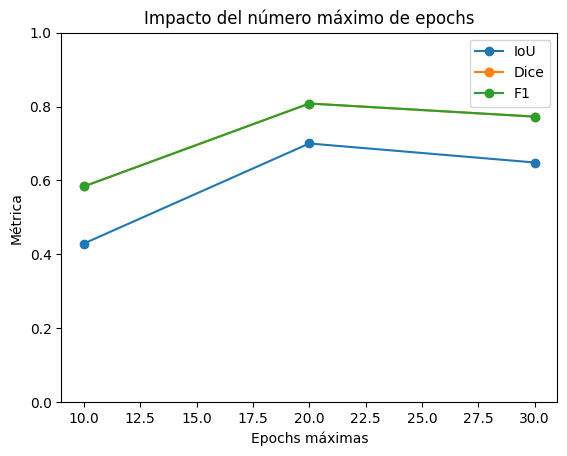

In [39]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df_epochs["Valor"], df_epochs["IoU"], marker="o", label="IoU")
plt.plot(df_epochs["Valor"], df_epochs["Dice"], marker="o", label="Dice")
plt.plot(df_epochs["Valor"], df_epochs["F1"], marker="o", label="F1")
plt.ylim(0, 1)
plt.title("Impacto del número máximo de epochs")
plt.xlabel("Epochs máximas")
plt.ylabel("Métrica")
plt.legend()
plt.show()


# *Evaluación 7.6*

Con un número reducido de épocas el modelo no alcanza una convergencia adecuada, mientras que un valor intermedio permite obtener el mejor rendimiento de segmentación. Incrementar el número máximo de épocas no aporta mejoras adicionales y puede incluso degradar ligeramente el rendimiento, lo que intensifica la importancia de fijar un presupuesto de entrenamiento adecuado.

# 7.7 Tamaño del conjunto de entrenamiento

Número de imágenes utilizadas para entrenar el modelo. Se evaluaron tres tamaños distintos (50, 75 y 100 imágenes) para analizar cómo la cantidad de datos influye en el aprendizaje.

In [40]:
def load_data_n(path, img_size, num_images):
    images, masks = [], []

    img_list  = sorted(os.listdir(path + "/Original"))[:num_images]
    mask_list = sorted(os.listdir(path + "/Ground truth"))[:num_images]

    for img_file, mask_file in zip(img_list, mask_list):
        img_path  = os.path.join(path + "/Original", img_file)
        mask_path = os.path.join(path + "/Ground truth", mask_file)

        img  = load_img(img_path,  target_size=img_size)
        mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")

        img  = img_to_array(img) / 255.0
        mask = img_to_array(mask) / 255.0
        mask = (mask > 0.5).astype("float32")

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)


In [41]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

train_sizes = [50, 75, 100]

IMG_SIZE = (512, 512)
BATCH_TRAIN = 2
BATCH_TEST = 2

BASE_FILTERS = 32
LR = 1e-3
EPOCHS = 20
PATIENCE = 5
THRESH_EVAL = 0.3

# Test fijo (cárgalo una vez)
x_test_fixed, y_test_fixed = load_data_n(f"{download_path}/test", IMG_SIZE, num_images=100)
test_dataset_clean = tf_dataset(x_test_fixed, y_test_fixed, batch_size=BATCH_TEST, shuffle=False)

rows = []

for n in train_sizes:
    tf.keras.backend.clear_session()

    # Train variable
    x_train_n, y_train_n = load_data_n(f"{download_path}/train", IMG_SIZE, num_images=n)
    train_dataset_n = tf_dataset(x_train_n, y_train_n, batch_size=BATCH_TRAIN, shuffle=True)

    model = build_model_filters(base_filters=BASE_FILTERS, input_shape=(512, 512, 3))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
        loss=dice_loss,
        metrics=["accuracy"]
    )

    ckpt_path = f"best_trainsize_{n}.keras"
    checkpoint = ModelCheckpoint(ckpt_path, monitor="val_loss",
                                 save_best_only=True, mode="min", verbose=0)
    early_stopping = EarlyStopping(monitor="val_loss", patience=PATIENCE,
                                   mode="min", verbose=0, restore_best_weights=True)

    model.fit(
        train_dataset_n,
        epochs=EPOCHS,
        validation_data=test_dataset_clean,
        callbacks=[checkpoint, early_stopping],
        verbose=0
    )

    best_model = tf.keras.models.load_model(ckpt_path, compile=False)
    iou, dice, f1 = evaluate_model(best_model, test_dataset_clean, threshold=THRESH_EVAL)

    rows.append({
        "Aspecto": "TrainSize",
        "Valor": n,
        "Threshold_eval": THRESH_EVAL,
        "IoU": iou,
        "Dice": dice,
        "F1": f1
    })

df_trainsize = pd.DataFrame(rows)
df_trainsize


,Aspecto,Valor,Threshold_eval,IoU,Dice,F1
0,TrainSize,50,0.300,0.430,0.584,0.584
1,TrainSize,75,0.300,0.679,0.792,0.792
2,TrainSize,100,0.300,0.683,0.794,0.794


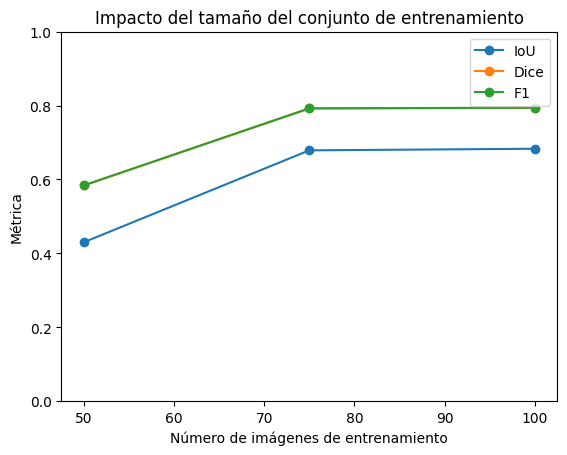

In [42]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df_trainsize["Valor"], df_trainsize["IoU"], marker="o", label="IoU")
plt.plot(df_trainsize["Valor"], df_trainsize["Dice"], marker="o", label="Dice")
plt.plot(df_trainsize["Valor"], df_trainsize["F1"], marker="o", label="F1")
plt.ylim(0, 1)
plt.title("Impacto del tamaño del conjunto de entrenamiento")
plt.xlabel("Número de imágenes de entrenamiento")
plt.ylabel("Métrica")
plt.legend()
plt.show()


# *Evaluación 7.7*

Al aumentar el número de imágenes disponibles para entrenar, el rendimiento de segmentación mejora de forma notable, especialmente al pasar de 50 a 75 imágenes. Sin embargo, al incrementar el tamaño hasta 100 imágenes la ganancia es llega a la saturación del rendimiento para el presupuesto de entrenamiento considerado.

# 7.8 Dropout

Técnica de regularización que desactiva aleatoriamente un porcentaje de neuronas durante el entrenamiento. Se evaluaron tres valores de dropout (0.0, 0.3 y 0.5) para estudiar su impacto en la capacidad de generalización del modelo.

In [43]:
from tensorflow.keras.layers import Dropout

def build_model_dropout(base_filters=32, dropout_rate=0.0, input_shape=(512,512,3)):
    inputs = Input(shape=input_shape)

    x1, p1 = encoder_block(inputs, base_filters)
    x2, p2 = encoder_block(p1, base_filters * 2)
    x3, p3 = encoder_block(p2, base_filters * 4)
    x4, p4 = encoder_block(p3, base_filters * 8)

    a1 = conv_block(p4, base_filters * 16)
    if dropout_rate > 0:
        a1 = Dropout(dropout_rate)(a1)

    d1 = decoder_block(a1, x4, base_filters * 8)
    d2 = decoder_block(d1, x3, base_filters * 4)
    d3 = decoder_block(d2, x2, base_filters * 2)
    d4 = decoder_block(d3, x1, base_filters)

    outputs = Conv2D(1, (1,1), padding="same", activation="sigmoid")(d4)
    return Model(inputs, outputs)


In [44]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

dropout_rates = [0.0, 0.3, 0.5]

LR = 1e-3
THRESH_EVAL = 0.3
EPOCHS = 20
PATIENCE = 5
BASE_FILTERS = 32

rows = []

for dr in dropout_rates:
    tf.keras.backend.clear_session()

    model = build_model_dropout(
        base_filters=BASE_FILTERS,
        dropout_rate=dr,
        input_shape=(512,512,3)
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
        loss=dice_loss,
        metrics=["accuracy"]
    )

    ckpt_path = f"best_dropout_{dr}.keras"
    checkpoint = ModelCheckpoint(ckpt_path, monitor="val_loss",
                                 save_best_only=True, mode="min", verbose=0)

    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=PATIENCE,
        mode="min",
        restore_best_weights=True,
        verbose=0
    )

    model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=test_dataset_clean,
        callbacks=[checkpoint, early_stopping],
        verbose=0
    )

    best_model = tf.keras.models.load_model(ckpt_path, compile=False)
    iou, dice, f1 = evaluate_model(best_model, test_dataset_clean, threshold=THRESH_EVAL)

    rows.append({
        "Aspecto": "Dropout",
        "Valor": dr,
        "Threshold_eval": THRESH_EVAL,
        "IoU": iou,
        "Dice": dice,
        "F1": f1
    })

df_dropout = pd.DataFrame(rows)
df_dropout


,Aspecto,Valor,Threshold_eval,IoU,Dice,F1
0,Dropout,0.000,0.300,0.691,0.802,0.802
1,Dropout,0.300,0.300,0.706,0.812,0.812
2,Dropout,0.500,0.300,0.687,0.799,0.799


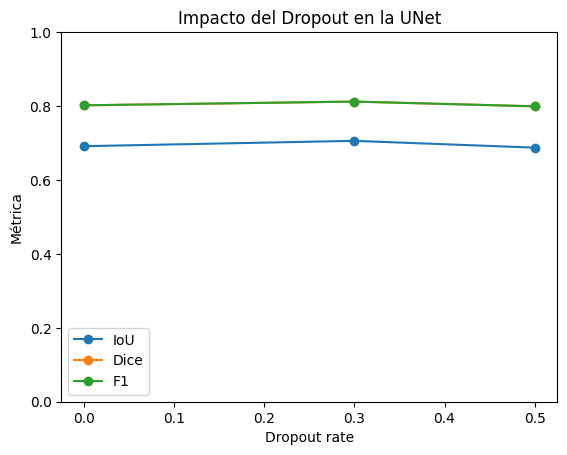

In [45]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df_dropout["Valor"], df_dropout["IoU"], marker="o", label="IoU")
plt.plot(df_dropout["Valor"], df_dropout["Dice"], marker="o", label="Dice")
plt.plot(df_dropout["Valor"], df_dropout["F1"], marker="o", label="F1")
plt.ylim(0, 1)
plt.title("Impacto del Dropout en la UNet")
plt.xlabel("Dropout rate")
plt.ylabel("Métrica")
plt.legend()
plt.show()


# *Evaluación 7.8*

La ausencia de Dropout permite un buen ajuste al conjunto de entrenamiento. Otros valores probados no mejoran la capacidad de generalización del modelo. En nuestro caso, parece irrelevante por el momento.

# **8.- Conclusión**

En este proyecto se ha evaluado de forma sistemática el rendimiento de una arquitectura UNet para segmentación mediante la variación controlada de distintos hiperparámetros y parámetros arquitectónicos.


---


A lo largo de los experimentos se ha puesto de manifiesto la importancia de seleccionar adecuadamente la función de pérdida y el threshold de inferencia en escenarios con fuerte desbalance entre fondo y objeto. Además, se ha observado que tanto el learning rate como la paciencia del EarlyStopping influyen de manera significativa en la convergencia y la generalización del modelo. Los experimentos arquitectónicos muestran que un aumento excesivo de la complejidad del modelo no garantiza mejores resultados cuando el conjunto de datos es reducido.


---


Finalmente, los resultados confirman que la combinación de una arquitectura ajustada, una función de pérdida adecuada y una regularización moderada permite mejorar sustancialmente las métricas de segmentación IoU, Dice y F1-score.